In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [2]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
print("\n Jumlah Missing Values : ")
print(df.isnull().sum())


 Jumlah Missing Values : 
Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


Pada df.isnull().sum() diatas terdapat 219 yang bernilai NaN, Namun pada dataset ini. Nilai Nan berarti bahwa tidak terdapat gangguan tidur yang dialami (insomnia ataupun Sleep Anea)

In [6]:
# Cek jumlah data yang duplikat (baris yang sama persis)
print("\nJumlah Data Duplikat:")
df.duplicated().sum()



Jumlah Data Duplikat:


np.int64(0)

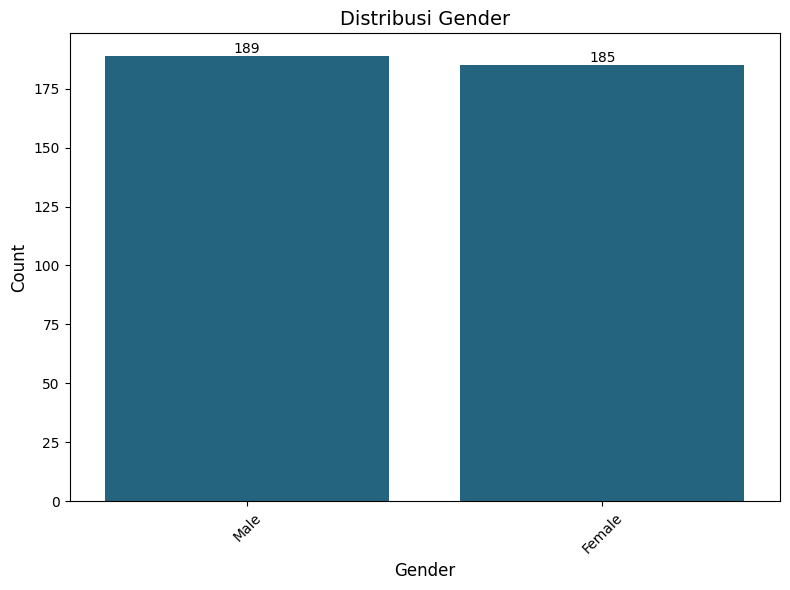

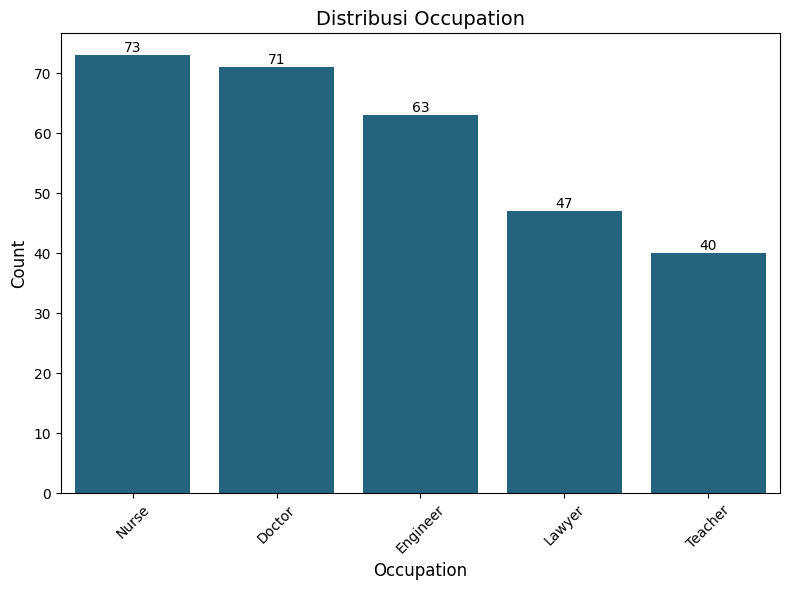

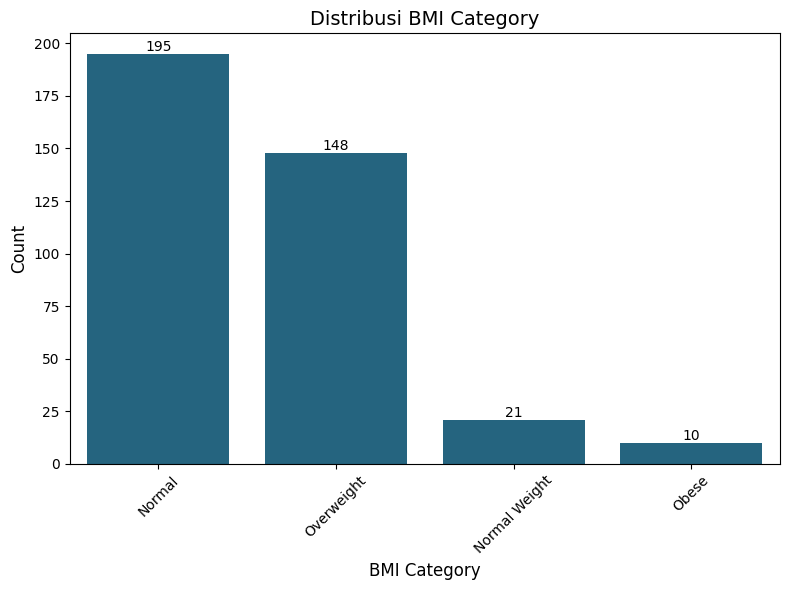

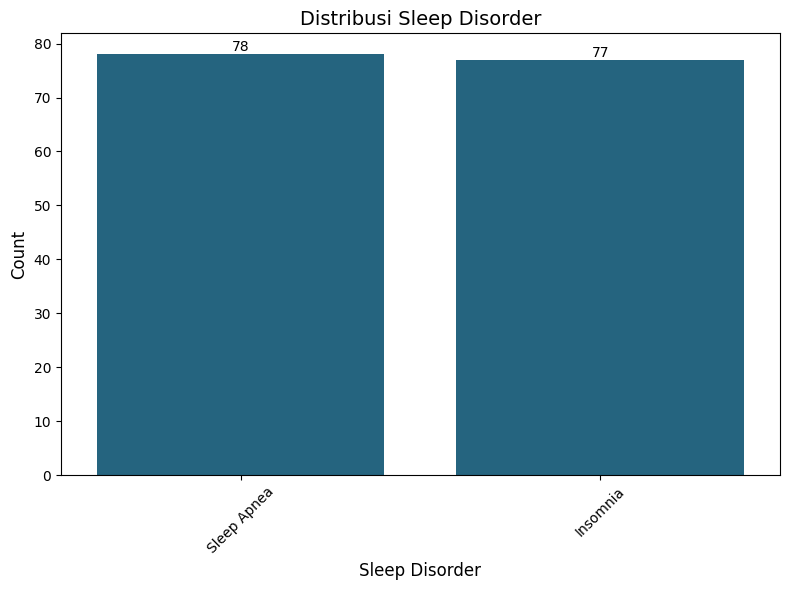

In [7]:
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
for feature in categorical_cols:
    plt.figure(figsize=(8, 6))

    # Ambil hanya 16 kategori paling sering muncul
    top_categories = df[feature].value_counts().nlargest()

    ax = sns.barplot(x=top_categories.index, y=top_categories.values, color="#166A8E")
    ax.bar_label(ax.containers[0], label_type='edge')  

    plt.title(f'Distribusi {feature}', fontsize=14)
    plt.xticks(rotation=45) 
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()

    plt.show()

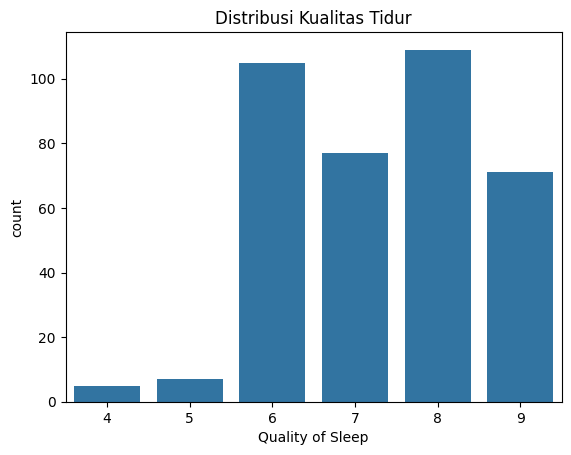

In [8]:
sns.countplot(data=df, x='Quality of Sleep')
plt.title('Distribusi Kualitas Tidur')
plt.show()

Pada distribusi kualitar tidur terdapat orang dengan tidur 4 sampai 9 Jam. Pada distribusi ini, kebanyakan orang sudah memiliki waktu tidur yang cukup.

In [12]:
numerical_cols = ['Age', 'Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Quality of Sleep']

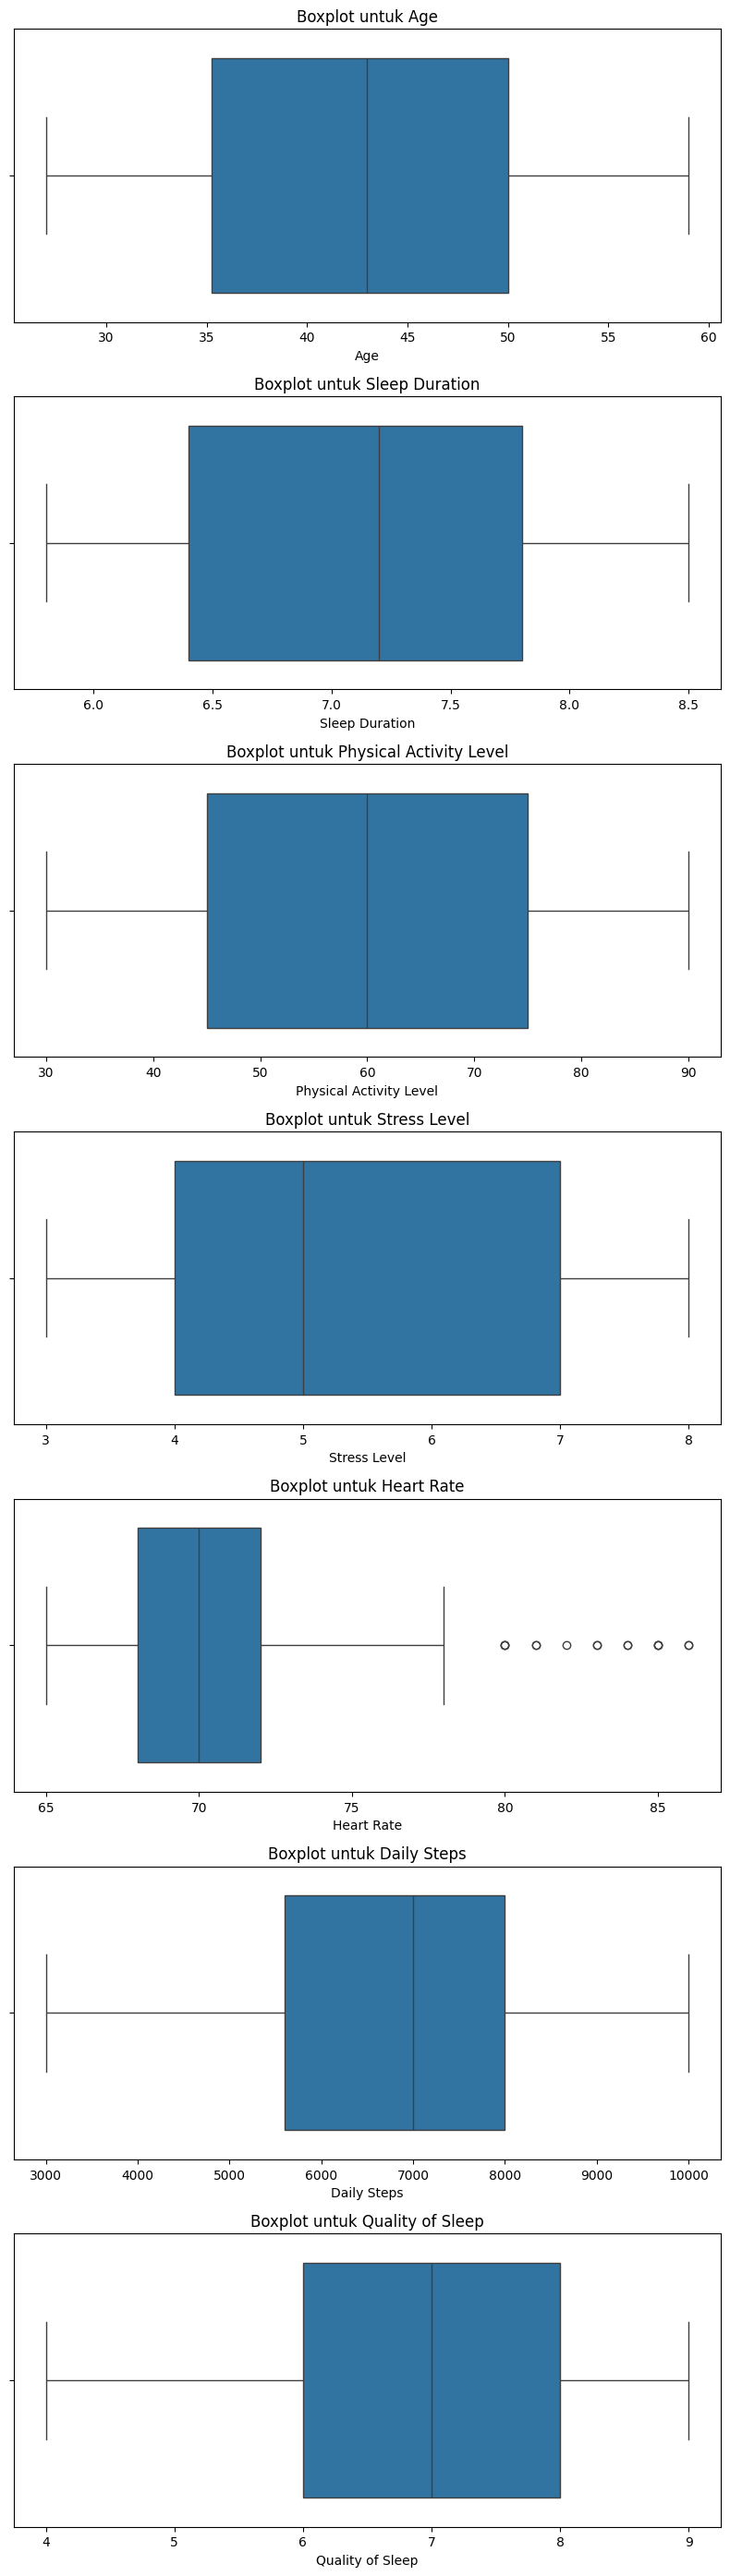

In [13]:
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(8, 4 * len(numerical_cols)))

# Plot boxplot untuk setiap kolom numerik
for ax, col in zip(axes, numerical_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot untuk {col}')

plt.tight_layout()
plt.show()

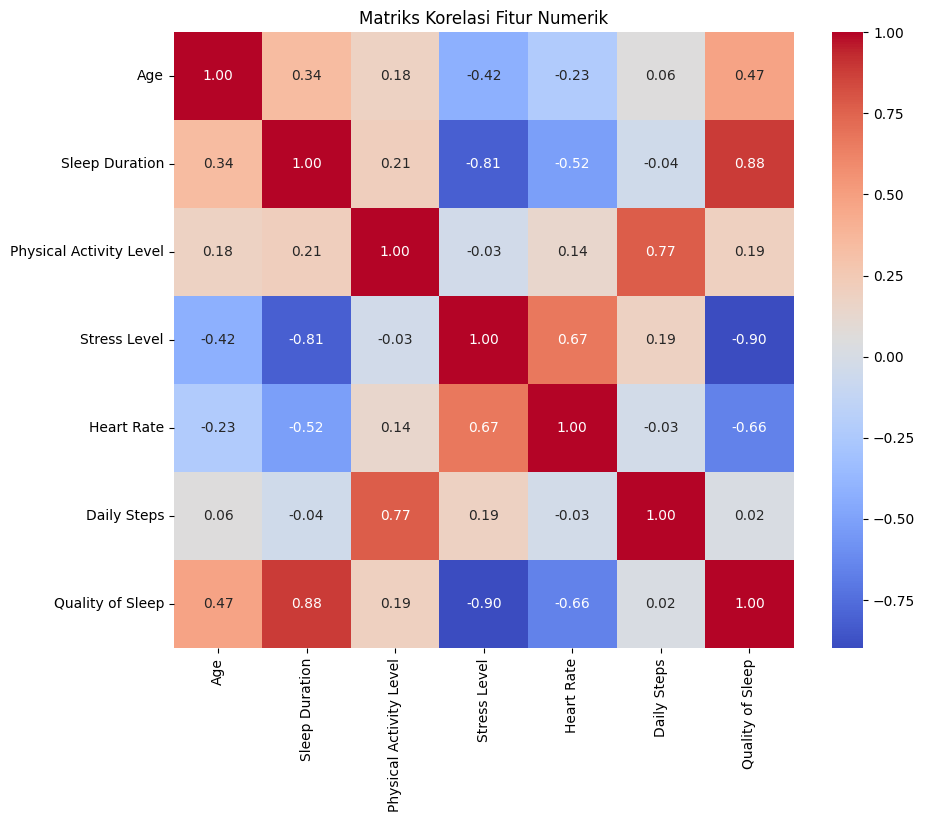

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi Fitur Numerik')
plt.show()

*Penjelasan : (Heatmap Matrik)*
- Durasi Tidur dan Kualitas Tidur (0.88): Ada korelasi positif yang sangat kuat. Ini menunjukkan bahwa durasi tidur yang lebih lama sangat terkait dengan kualitas tidur yang lebih tinggi, yang masuk akal secara intuitif.
- Tingkat Stres dan Kualitas Tidur (-0.90): Ada korelasi negatif yang sangat kuat. Ini menunjukkan bahwa seiring dengan peningkatan tingkat stres, kualitas tidur cenderung menurun secara signifikan.
- Tingkat Stres dan Durasi Tidur (-0.81): Korelasi negatif yang kuat, menyiratkan bahwa tingkat stres yang lebih tinggi dikaitkan dengan durasi tidur yang lebih pendek.
- Tingkat Aktivitas Fisik dan Langkah Harian (0.77): Korelasi positif yang kuat, yang diharapkan karena aktivitas fisik yang lebih banyak umumnya berarti lebih banyak langkah harian.
- Tingkat Stres dan Detak Jantung (0.67): Korelasi positif yang cukup kuat. Tingkat stres yang lebih tinggi sering dikaitkan dengan peningkatan detak jantung.
- Usia dan Durasi Tidur (0.34): Korelasi positif yang lemah. Ini menunjukkan sedikit kecenderungan bagi individu yang lebih tua untuk memiliki durasi tidur yang lebih lama, tetapi itu bukan hubungan yang kuat.
- Langkah Harian dan Kualitas Tidur (0.02): Korelasi positif yang sangat lemah, hampir dapat diabaikan. Ini menyiratkan bahwa jumlah langkah harian memiliki sedikit atau tidak ada hubungan linier dengan kualitas tidur berdasarkan data ini.

# Data Preprocessing

In [15]:
df = df.drop('Person ID', axis=1)
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')

*Penjelasan :* 
- Melakukan Dropping pada kolom Person ID
- Mengisi nilai yang hilang atau NaN pada kolom 'Sleep Disorder' dengan No Disorder (Tidak memiliki gangguan tidur)

In [16]:
df.head(7)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,No Disorder
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disorder
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disorder
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia


In [19]:
print(f"Jumlah Missing Values :\n{df.isnull().sum()}")

Jumlah Missing Values :
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64


In [30]:
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df = df.drop('Blood Pressure', axis=1)

*Penjelasan :*
- Memisahkan nilai pada kolom 'Blood Pressure' yang bertipe data string menjadi 'Systolic BP', 'Diastolic BP' menjadi 2 kolom numerik yang terpisang.

In [31]:
df['Quality of Sleep_Category'] = df['Quality of Sleep'].apply(lambda x: 'Good' if x > 7 else 'Bad')
le_quality = LabelEncoder()
df['Quality of Sleep_Encoded'] = le_quality.fit_transform(df['Quality of Sleep_Category'])
# Simpan mapping untuk interpretasi hasil evaluasi
quality_mapping = dict(zip(le_quality.classes_, le_quality.transform(le_quality.classes_)))
print(f"Quality of Sleep Mapping: {quality_mapping}")

# Simpan mapping untuk interpretasi hasil evaluasi
quality_mapping = dict(zip(le_quality.classes_, le_quality.transform(le_quality.classes_)))
print(f"Quality of Sleep Mapping: {quality_mapping}")

Quality of Sleep Mapping: {'Bad': np.int64(0), 'Good': np.int64(1)}
Quality of Sleep Mapping: {'Bad': np.int64(0), 'Good': np.int64(1)}


*Penjelasan :*
- Kolom Quality of Sleep_Category yang memiliki rentang nilai dari 1 - 10. Akan dikategorikan menjadi 2 kelas : Baik dan Buruk. Kategori akan bernilai Good (Baik apabila skor > 7) dan akan bernilai Bad (Buruk apabila skro <6 )

In [32]:
X = df.drop(['Quality of Sleep', 'Quality of Sleep_Category', 'Quality of Sleep_Encoded'], axis=1)
y = df['Quality of Sleep_Encoded']

In [33]:
# Encoding Fitur Kategorikal (melakukan Label Encoding untuk kesederhanaan awal)
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [34]:
#  Penskalaan/Normalisasi Fitur Numerik
numericals_cols = ['Age', 'Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP']
scaler = StandardScaler()
X[numericals_cols] = scaler.fit_transform(X[numericals_cols])

In [35]:
# Pembagian Data Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nData setelah pra-pemrosesan:")
print(X_train.head())
print(y_train.value_counts())


Data setelah pra-pemrosesan:
     Gender       Age  Occupation  Sleep Duration  Physical Activity Level  \
104       0 -0.714018          10        0.085471                 0.039844   
116       0 -0.598565           0        0.085471                 0.039844   
74        1 -1.060377           1       -1.424738                -1.402260   
278       0  0.902324           5       -1.298887                 1.481948   
176       1 -0.136753           3        0.588874                 1.481948   

     Stress Level  BMI Category  Heart Rate  Daily Steps  Sleep Disorder  \
104     -0.781551             0   -0.524383     0.113356               2   
116     -0.781551             0   -0.524383     0.113356               1   
74       1.475592             0    0.444107    -1.124458               1   
278      1.475592             3    1.170474     1.970077               0   
176     -0.217265             0   -0.040138     0.732263               1   

     Systolic BP  Diastolic BP  
104    -1.7